# Cu cluster neural network potential
In this demonstration, we fit a simple neural network potential model on Cu cluster data utilizing the SOAP descriptor and it's derivatives.


## Data
The data set for the demonstration was generated by running a LAMMPS MD simulation with input file `lammps_data/cu_cluster.in`. It simulates the dynamics of a 55-atom Cu cluster at 500 K for 5.0 ns and saves the atomic structure every 0.5 ps into dump file `lammps_data/cu_cluster.dump`. The result is a data set of 10 000 atomic structures and their potential energies that we can use to fit and test the machine learning model.

Reading the data:

In [1]:
import numpy as np
from ase import Atoms
from ase.io import read

structures = read("data/cu_cluster.dump", "1::")  # leaving the initial structure out
e_pot = np.array([np.sum(s.get_array("c_ep")) for s in structures])  # total potential energies
f = np.array([s.get_forces() for s in structures])

# Redefining the atomic structures with proper elemental information
structures = [Atoms(len(s) * ["Cu"], s.positions, cell=s.cell, pbc=False) for s in structures]

# Defining the labels by shifting the potential energies
y = e_pot - np.mean(e_pot)

We split the data set randomly to training and test sets with a 80%-20% split:

In [2]:
N_train = int(0.8 * len(y))

rng = np.random.RandomState(seed=0)
shuffle_ind = np.arange(len(y))
rng.shuffle(shuffle_ind)

s_tr = [structures[i] for i in shuffle_ind[:N_train]]
y_tr = y[shuffle_ind][:N_train]
f_tr = f[shuffle_ind][:N_train]

s_te = [structures[i] for i in shuffle_ind[N_train:]]
y_te = y[shuffle_ind][N_train:]
f_te = f[shuffle_ind][N_train:]

## ML model

### SOAP descriptor
We represent the atomic structures in vector form using the Smooth Overlap of Atomic Positions (SOAP) descriptor. We use a cutoff radius of 6.0 Å and a basis of 8 radial basis functions and 6 spherical harmonics.

Descriptor definition:

In [3]:
from dscribe.descriptors import SOAP

species = ["Cu"]
r_cut = 6.0
n_max = 8
l_max = 6

soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    dtype="float32",
)

X = soap.create(structures, n_jobs=-1)

X_tr = X[shuffle_ind][:N_train]
X_te = X[shuffle_ind][N_train:]

### PCA

The first layer of the atomic neural network will use principal component analysis (PCA) to reduce the dimensionality of the input SOAP vector to 50. To configure such a layer, we fit a PCA model on the training data and store the model parameters in Tensorflow tensors.

In [4]:
from sklearn.decomposition import PCA
import tensorflow as tf

original_shape = X_tr.shape
X_tr_atoms = X_tr.reshape((-1, X.shape[-1]))
pca = PCA(n_components=50)
pca.fit(X_tr_atoms)

pca_mean = tf.convert_to_tensor(pca.mean_, dtype=tf.float32)
pca_components = tf.convert_to_tensor(pca.components_, dtype=tf.float32)

2023-05-25 16:33:57.940254: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 16:33:58.051713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 16:33:58.419031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 16:33:58.419556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 16:34:03.236001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Neural network
Setting up a neural network that takes the SOAP vectors of the 55 Cu atoms, performs PCA dimensionality reduction on all of them, maps the PCA-reduced SOAP vector to atomic energies using a dense feedforward neural network with two hidden layers, and sums the atomic energies together to obtain the total potential energy:

In [5]:
import numpy as np
import random
import tensorflow as tf

from tensorflow import unstack
from tensorflow.math import reduce_sum
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from keras import backend

backend.set_floatx("float32")

def init_model(seed=0):
    
    # Setting the random seeds for reproducibility
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    # Hyperparameters of the two hidden layers
    n_nodes = 50
    activation = "sigmoid"

    # Defining the atomic neural network
    single_atom_input = Input((X.shape[-1],), dtype=tf.float32)
    x = tf.tensordot(single_atom_input - pca_mean, tf.transpose(pca_components), axes=1)  # PCA layer
    x = Dense(n_nodes, activation=activation)(x)
    x = Dense(n_nodes, activation=activation)(x)
    x = Dense(1, activation="linear")(x)
    single_atom_model = Model(single_atom_input, x)

    # Stacking atomic neural networks so that there is one for each atom in the system
    input = Input(X[0].shape, dtype=tf.float32)
    splits = unstack(input, axis=-2)
    towers = [single_atom_model(split) for split in splits]
    merge_layer = Concatenate()(towers)
    output_layer = reduce_sum(merge_layer, axis=-1)
    model = Model(input, output_layer)

    model.compile(loss="mse", optimizer=Adam(learning_rate=0.00005))
    
    return model

## Model fitting and testing
We fit the neural network model multiple times with different trainig set sizes ranging from 250 to 8 000. We use each model to predict the energies and forces of the 2 000 test set structures to obtain learning curves for the model.

First, we define functions for force and energy tests:

In [6]:
def test_energy_prediction(model, output_path=None):
    y_pr = model.predict(X_te)
    if output_path:
        np.save(output_path, y_pr)
        
    return np.mean(np.abs(y_te - y_pr))


def test_force_prediction(model, output_path=None):
    f_ml = np.zeros(f_te.shape)

    # Compute forces of 20 structures at a time to save memory
    batch_size = 20

    for start in range(0, f_te.shape[0], batch_size):
        end = min(start + batch_size, f_ml.shape[0])
        st = s_te[start:end]

        if start % 100 == 0:
            print(f"Evaluated structures: {start}")

        # Evaluate SOAP derivatives with respect to atomic coordinates
        dX_dR, X = soap.derivatives(st, attach=True, n_jobs=-1)

        # Evaluate energy derivatives with respect to SOAP vectors
        x = tf.constant(X)
        with tf.GradientTape() as g:
            g.watch(x)
            e = model(x)
        dE_dX = g.gradient(e, x)

        # Use chain rule to evaluate energy derivatives with respect to atomic coordinates (forces)
        f_ml[start:end] = -np.sum(dE_dX[:, :, np.newaxis, np.newaxis, :] * dX_dR, axis=(1, 4))
    
    if output_path:
        np.save(output_path, f_ml)
    
    return np.mean(np.abs(f_ml - f_te))

Then, we fit the models and predict test set energies and forces with each model:

In [7]:
import os

if not os.path.exists("models"):
    os.makedirs("models")

if not os.path.exists("predictions"):
    os.makedirs("predictions")
    
for n_tr in [250, 500, 1000, 2000, 4000, 8000]:
    model = init_model()
    model.fit(X_tr[:n_tr], y_tr[:n_tr], epochs=2000, verbose=0, validation_split=0.2)
    model.save(f"models/model_{n_tr}")
    mae_e = test_energy_prediction(model, f"predictions/e_ml_{n_tr}")
    mae_f = test_force_prediction(model, f"predictions/f_ml_{n_tr}")
    print(n_tr, mae_e, mae_f)

2023-05-25 16:35:27.459625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,252]
	 [[{{node input_1}}]]
2023-05-25 16:35:27.476944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,252]
	 [[{{node input_1}}]]
2023-05-25 16:35:27.492297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-25 1

INFO:tensorflow:Assets written to: models/model_250/assets


INFO:tensorflow:Assets written to: models/model_250/assets


63/63 [==============================] - 1s 1ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
250 0.17501180645567088 0.3618825017650805


2023-05-25 16:38:09.648934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_3' with dtype float and shape [?,252]
	 [[{{node input_3}}]]
2023-05-25 16:38:09.665723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_3' with dtype float and shape [?,252]
	 [[{{node input_3}}]]
2023-05-25 16:38:09.678521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-25 1

INFO:tensorflow:Assets written to: models/model_500/assets


INFO:tensorflow:Assets written to: models/model_500/assets


63/63 [==============================] - 1s 1ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
500 0.11094016318352329 0.2646158639466146


2023-05-25 16:41:40.801127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,252]
	 [[{{node input_5}}]]
2023-05-25 16:41:40.817850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,252]
	 [[{{node input_5}}]]
2023-05-25 16:41:40.830571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-25 1

INFO:tensorflow:Assets written to: models/model_1000/assets


INFO:tensorflow:Assets written to: models/model_1000/assets


63/63 [==============================] - 1s 1ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
1000 0.06514740973846969 0.15392673555615824


2023-05-25 16:46:58.488205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_7' with dtype float and shape [?,252]
	 [[{{node input_7}}]]
2023-05-25 16:46:58.505267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_7' with dtype float and shape [?,252]
	 [[{{node input_7}}]]
2023-05-25 16:46:58.518963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-25 1

INFO:tensorflow:Assets written to: models/model_2000/assets


INFO:tensorflow:Assets written to: models/model_2000/assets


63/63 [==============================] - 1s 1ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
2000 0.037347782394123015 0.08347957256914205


2023-05-25 16:55:46.078035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_9' with dtype float and shape [?,252]
	 [[{{node input_9}}]]
2023-05-25 16:55:46.094889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_9' with dtype float and shape [?,252]
	 [[{{node input_9}}]]
2023-05-25 16:55:46.108316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-25 1

INFO:tensorflow:Assets written to: models/model_4000/assets


INFO:tensorflow:Assets written to: models/model_4000/assets


63/63 [==============================] - 1s 1ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
4000 0.02509561807241724 0.05347953562042493


2023-05-25 17:11:48.604623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_11' with dtype float and shape [?,252]
	 [[{{node input_11}}]]
2023-05-25 17:11:48.621370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_11' with dtype float and shape [?,252]
	 [[{{node input_11}}]]
2023-05-25 17:11:48.633919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,252]
	 [[{{node inputs}}]]
2023-05-

INFO:tensorflow:Assets written to: models/model_8000/assets


INFO:tensorflow:Assets written to: models/model_8000/assets


63/63 [==============================] - 1s 2ms/step
Evaluated structures: 0
Evaluated structures: 100
Evaluated structures: 200
Evaluated structures: 300
Evaluated structures: 400
Evaluated structures: 500
Evaluated structures: 600
Evaluated structures: 700
Evaluated structures: 800
Evaluated structures: 900
Evaluated structures: 1000
Evaluated structures: 1100
Evaluated structures: 1200
Evaluated structures: 1300
Evaluated structures: 1400
Evaluated structures: 1500
Evaluated structures: 1600
Evaluated structures: 1700
Evaluated structures: 1800
Evaluated structures: 1900
8000 0.01885812988132446 0.038864502710501084


Plotting the learning curves:

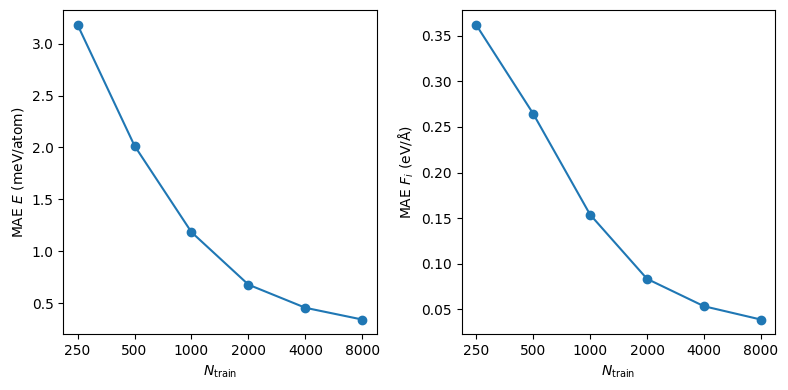

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mae_e = []
mae_f = []
n_train = [250, 500, 1000, 2000, 4000, 8000]

for n_tr in n_train:
    y_ml = np.load(f"predictions/e_ml_{n_tr}.npy")
    f_ml = np.load(f"predictions/f_ml_{n_tr}.npy")
    
    mae_e.append(np.mean(np.abs(y_ml-y_te)))
    mae_f.append(np.mean(np.abs(f_ml-f_te)))
    
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)

# Plot energy learning curve
ax = axs[0]

ax.semilogx(n_train, np.array(mae_e)/55*1000, '-o')
ax.set_xlabel("$N_{\mathrm{train}}$")
ax.set_ylabel("MAE $E$ (meV/atom)")
ax.set_xticks(n_train, [str(n_tr) for n_tr in n_train], minor=False)
ax.set_xticks([], minor=True)

# Plot forces
ax = axs[1]

ax.semilogx(n_train, mae_f, '-o')
ax.set_xlabel("$N_{\mathrm{train}}$")
ax.set_ylabel("MAE $F_i$ (eV/Å)")
ax.set_xticks(n_train, [str(n_tr) for n_tr in n_train], minor=False)
ax.set_xticks([], minor=True)

plt.tight_layout()

Finally, we plot scatter plots that compare the energy and force predictions from the model that was trained with all 8 000 traing structures to the EAM reference values:

Energy MAE (ev/atom): 0.0003428750887513538
Force MAE (eV/Å): 0.038864502710501084


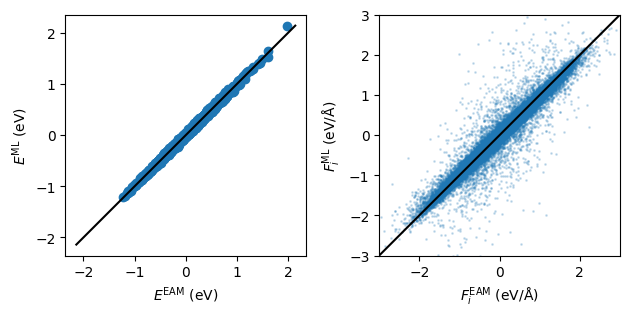

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

# Plot energies
ax = axs[0]
x = y_te
y = np.load("predictions/e_ml_8000.npy")
print("Energy MAE (ev/atom):", np.mean(np.abs(x-y))/55)

ax.scatter(x, y)
ma = max(np.max(np.abs(x)), np.max(np.abs(y)))
ax.plot([-ma, ma], [-ma, ma], "-k")

ax.set_xlabel("$E^{\mathrm{EAM}}$ (eV)")
ax.set_ylabel("$E^{\mathrm{ML}}$ (eV)")
ax.set_aspect("equal")


# Plot forces
ax = axs[1]
x = f_te.flatten()
y = np.load("predictions/f_ml_8000.npy").flatten()
print("Force MAE (eV/Å):", np.mean(np.abs(x-y)))

ax.scatter(x, y, s=1, alpha=0.2)
ma = max(np.max(np.abs(x)), np.max(y))
ax.plot([-ma, ma], [-ma, ma], "-k")

ax.set_xlabel("$F_i^{\mathrm{EAM}}$ (eV/Å)")
ax.set_ylabel("$F_i^{\mathrm{ML}}$ (eV/Å)")
ax.set_aspect("equal")
ax.set_ylim((-3, 3))
ax.set_xlim((-3, 3))
plt.tight_layout()